In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "2024_Wimbledon_featured_matches.csv"
DICT_PATH = "2024_data_dictionary.csv"

df = pd.read_csv(CSV_PATH)
dd = pd.read_csv(DICT_PATH)

print("df shape:", df.shape)
print("columns:", df.columns.tolist()[:20], "...")
display(dd.head() if 'display' in globals() else dd.head())

# # ---- 统一类型：一些列经常会被读成 object，先尽量转成数值（转不了的保留）----
# num_cols_try = [
#     "point_no","game_no","set_no",
#     "p1_sets","p2_sets","p1_games","p2_games",
#     "p1_points_won","p2_points_won",
#     "server","serve_no","point_victor",
#     "game_victor","set_victor",
#     "rally_count","speed_mph",
#     "p1_distance_run","p2_distance_run",
#     "p1_break_pt","p2_break_pt","p1_break_pt_won","p2_break_pt_won"
# ]
# for c in num_cols_try:
#     if c in df.columns:
#         df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- elapsed_time 转秒（格式类似 0:01:31）----
def elapsed_to_seconds(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    parts = s.split(":")
    try:
        if len(parts) == 3:
            h, m, sec = parts
            return int(h) * 3600 + int(m) * 60 + float(sec)
        if len(parts) == 2:
            m, sec = parts
            return int(m) * 60 + float(sec)
        return float(s)
    except:
        return np.nan

if "elapsed_time" in df.columns:
    df["elapsed_sec"] = df["elapsed_time"].apply(elapsed_to_seconds)

# ---- 辅助：把 point 是否由 server 赢出来（server_win=1/0）----
# point_victor: 1 表示 p1 赢，2 表示 p2 赢；server: 1 表示 p1 发球，2 表示 p2 发球
df["server_win"] = np.where(
    (df["point_victor"] == df["server"]),
    1,
    np.where(df["point_victor"].isin([1,2]) & df["server"].isin([1,2]), 0, np.nan)
)

# ---- 排序：保证 point 顺序正确 ----
df = df.sort_values(["match_id","set_no","game_no","point_no"]).reset_index(drop=True)


df shape: (7284, 46)
columns: ['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no', 'point_no', 'p1_sets', 'p2_sets', 'p1_games', 'p2_games', 'p1_score', 'p2_score', 'server', 'serve_no', 'point_victor', 'p1_points_won', 'p2_points_won', 'game_victor', 'set_victor'] ...


,variables,explanation,example
0,match_id,match identification,"2023-wimbledon-1701 (""7"" is the round, and ""01..."
1,player1,first and last name of the first player,Carlos Alcaraz
2,player2,first and last name of the second player,Novak Djokovic
3,elapsed_time,time elapsed since start of first point to sta...,0:10:27
4,set_no,set number in match,"1, 2, 3, 4, or 5"


matches: 31
points per match (min/median/max): 122 217.0 337


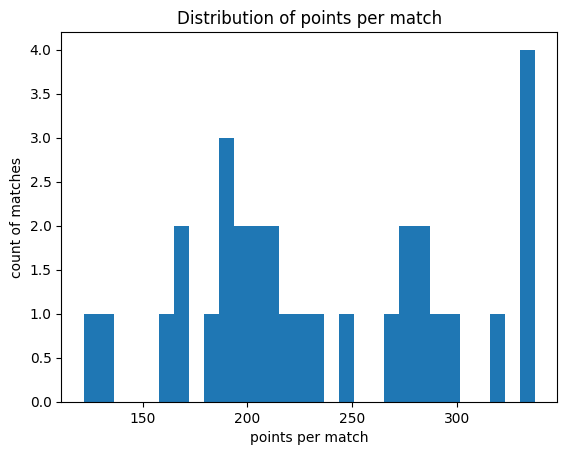

Duplicated (match_id, point_no): 0
count    31.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: missing_cnt, dtype: float64
Top matches with most missing point_no:
                     min  max  missing_cnt
match_id                                  
2023-wimbledon-1301    1  300            0
2023-wimbledon-1302    1  201            0
2023-wimbledon-1303    1  134            0
2023-wimbledon-1304    1  337            0
2023-wimbledon-1305    1  246            0
2023-wimbledon-1306    1  332            0
2023-wimbledon-1307    1  232            0
2023-wimbledon-1308    1  190            0
2023-wimbledon-1309    1  213            0
2023-wimbledon-1310    1  318            0


C:\Users\DELL\AppData\Local\Temp\ipykernel_83776\178810684.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = df.groupby("match_id").apply(check_gaps)


In [3]:
# 1) 每场比赛的 point 数
pts_per_match = df.groupby("match_id")["point_no"].count().sort_values(ascending=False)
print("matches:", pts_per_match.shape[0])
print("points per match (min/median/max):", pts_per_match.min(), pts_per_match.median(), pts_per_match.max())

plt.figure()
plt.hist(pts_per_match.values, bins=30)
plt.xlabel("points per match")
plt.ylabel("count of matches")
plt.title("Distribution of points per match")
plt.show()

# 2) 检查 (match_id, point_no) 唯一性
dup = df.duplicated(subset=["match_id","point_no"]).sum()
print("Duplicated (match_id, point_no):", dup)

# 3) 粗检：每场比赛 point_no 是否从 1 开始、是否有缺口（可能存在，但要知道）
def check_gaps(g):
    s = g["point_no"].dropna().astype(int).sort_values()
    if s.empty:
        return pd.Series({"min": np.nan, "max": np.nan, "missing_cnt": np.nan})
    full = np.arange(s.min(), s.max()+1)
    missing = np.setdiff1d(full, s.values)
    return pd.Series({"min": s.min(), "max": s.max(), "missing_cnt": len(missing)})

gaps = df.groupby("match_id").apply(check_gaps)
print(gaps["missing_cnt"].describe())
print("Top matches with most missing point_no:")
print(gaps.sort_values("missing_cnt", ascending=False).head(10))


Monotonic non-decreasing ratio (mean): 1.0
count    31.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_83776\2437336093.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mono = df.groupby("match_id").apply(monotonic_ratio).dropna()


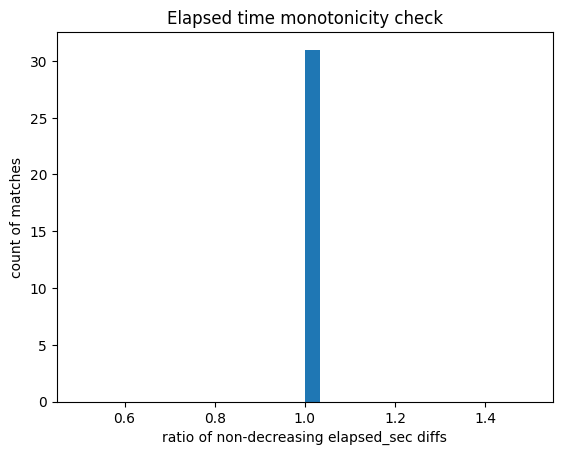

delta_t (sec) quantiles: {0.01: 15.0, 0.05: 18.0, 0.5: 34.0, 0.95: 106.0, 0.99: 147.0}


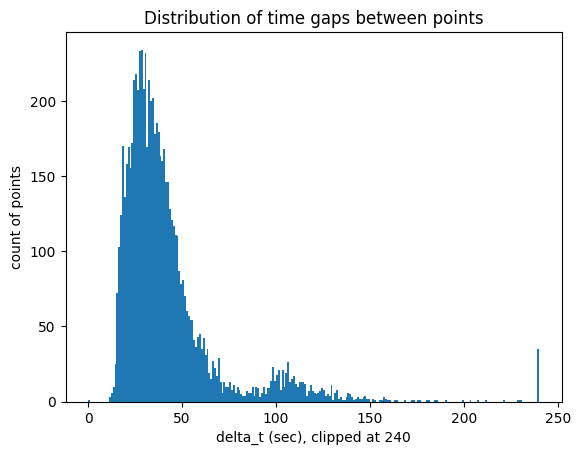

In [4]:
# 1) elapsed_sec 是否随 point_no 单调递增（每场比赛）
if "elapsed_sec" in df.columns:
    def monotonic_ratio(g):
        s = g.sort_values("point_no")["elapsed_sec"].dropna()
        if len(s) < 2:
            return np.nan
        return (s.diff().dropna() >= 0).mean()

    mono = df.groupby("match_id").apply(monotonic_ratio).dropna()
    print("Monotonic non-decreasing ratio (mean):", mono.mean())
    print(mono.describe())

    plt.figure()
    plt.hist(mono.values, bins=30)
    plt.xlabel("ratio of non-decreasing elapsed_sec diffs")
    plt.ylabel("count of matches")
    plt.title("Elapsed time monotonicity check")
    plt.show()

# 2) point 间隔分布（可看是否存在极端停顿）
if "elapsed_sec" in df.columns:
    g = df[df["match_id"].notna()].groupby("match_id", group_keys=False)
    df["delta_t"] = g["elapsed_sec"].diff()
    dt = df["delta_t"].dropna()
    print("delta_t (sec) quantiles:", dt.quantile([0.01,0.05,0.5,0.95,0.99]).to_dict())

    plt.figure()
    plt.hist(dt.clip(upper=240).values, bins=240)  # 截断到240秒方便看
    plt.xlabel("delta_t (sec), clipped at 240")
    plt.ylabel("count of points")
    plt.title("Distribution of time gaps between points")
    plt.show()


Overall P(server wins point): 0.6731191652937946
P(server wins) by serve_no:
serve_no
1    0.754134
2    0.529501
Name: server_win, dtype: float64


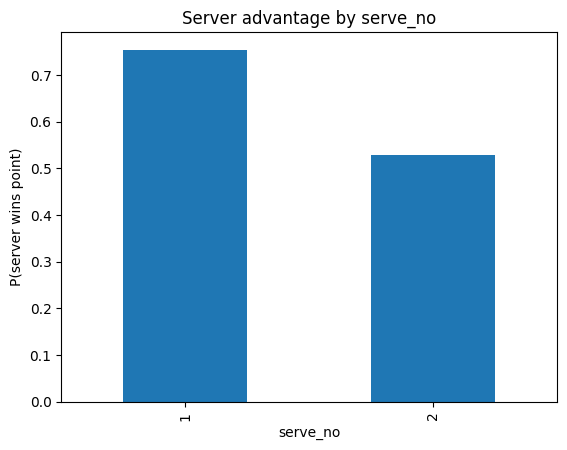

P(server wins) by break point (0/1):
is_break_pt
0    0.674926
1    0.648810
Name: server_win, dtype: float64


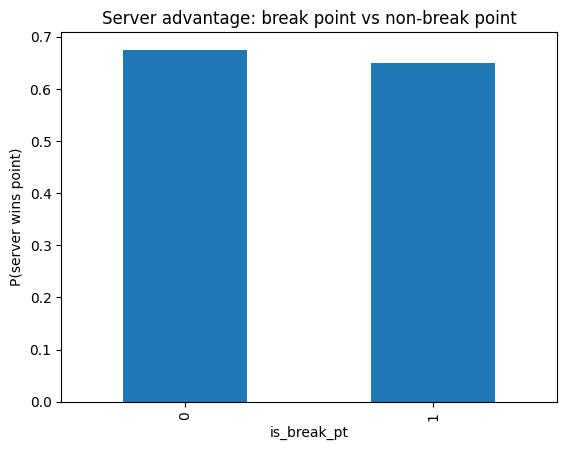

In [5]:
# 1) 整体 server 赢 point 概率
overall = df["server_win"].dropna().mean()
print("Overall P(server wins point):", overall)

# 2) 按 serve_no（一发/二发）
if "serve_no" in df.columns:
    by_serve_no = df.groupby("serve_no")["server_win"].mean()
    print("P(server wins) by serve_no:")
    print(by_serve_no)

    plt.figure()
    by_serve_no.plot(kind="bar")
    plt.ylabel("P(server wins point)")
    plt.title("Server advantage by serve_no")
    plt.show()

# 3) 按 break point（谁是 break point：p1_break_pt 或 p2_break_pt）
if "p1_break_pt" in df.columns and "p2_break_pt" in df.columns:
    df["is_break_pt"] = ((df["p1_break_pt"] == 1) | (df["p2_break_pt"] == 1)).astype(int)
    by_bp = df.groupby("is_break_pt")["server_win"].mean()
    print("P(server wins) by break point (0/1):")
    print(by_bp)

    plt.figure()
    by_bp.plot(kind="bar")
    plt.ylabel("P(server wins point)")
    plt.title("Server advantage: break point vs non-break point")
    plt.show()


Total runs counted: 3413
Run length (min/median/mean/max): 1 2.0 2.13419279226487 13
Run length top frequencies:
 1     1573
2      814
3      449
4      331
5      148
6       51
7       27
8       13
9        3
10       1
Name: count, dtype: int64


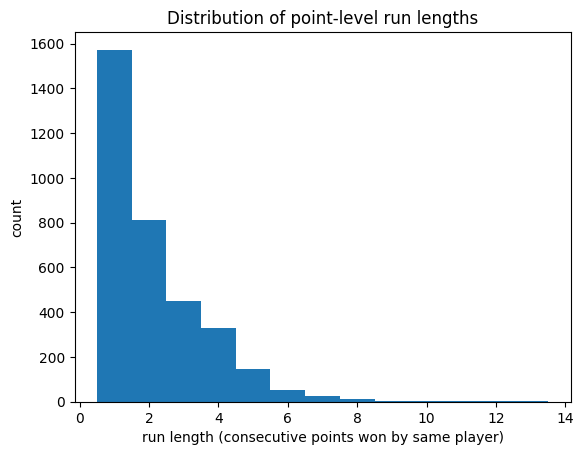

In [6]:
# 以 “某一方连续赢 point” 来定义 run
# 我们用 point_victor 序列，统计连续相同值的长度（忽略缺失）

def run_lengths(victor_series):
    v = victor_series.dropna().astype(int).values
    if len(v) == 0:
        return []
    runs = []
    cur = v[0]
    length = 1
    for x in v[1:]:
        if x == cur:
            length += 1
        else:
            runs.append(length)
            cur = x
            length = 1
    runs.append(length)
    return runs

runs_all = []
for mid, g in df.groupby("match_id"):
    r = run_lengths(g.sort_values("point_no")["point_victor"])
    runs_all.extend(r)

runs_all = np.array(runs_all)
print("Total runs counted:", len(runs_all))
print("Run length (min/median/mean/max):",
      runs_all.min(), np.median(runs_all), runs_all.mean(), runs_all.max())
print("Run length top frequencies:\n", pd.Series(runs_all).value_counts().head(10))

plt.figure()
plt.hist(runs_all, bins=np.arange(1, runs_all.max()+2)-0.5)
plt.xlabel("run length (consecutive points won by same player)")
plt.ylabel("count")
plt.title("Distribution of point-level run lengths")
plt.show()


matches analyzed: 31
fraction real_longest > sim 95th percentile: 0.03225806451612903
               match_id  n_points  p1_point_win_rate  real_longest_run  \
18  2023-wimbledon-1403       122           0.573770                13   
26  2023-wimbledon-1503       193           0.559585                12   
27  2023-wimbledon-1504       217           0.442396                11   
16  2023-wimbledon-1401       225           0.542222                10   
10  2023-wimbledon-1311       170           0.394118                 9   
9   2023-wimbledon-1310       318           0.512579                 9   
19  2023-wimbledon-1404       286           0.479021                 9   
12  2023-wimbledon-1313       290           0.534483                 8   
21  2023-wimbledon-1406       195           0.564103                 8   
20  2023-wimbledon-1405       215           0.558140                 8   

    sim_longest_95p  real_exceeds_95p  
18             12.0                 1  
26             12.0

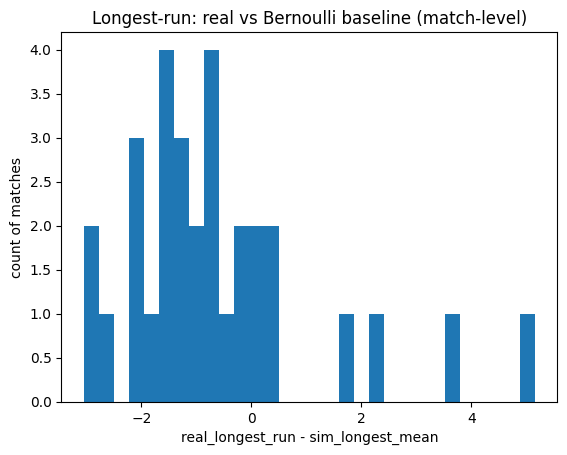

In [7]:
# 思路：对每场比赛，用该场的 overall p(某一固定球员赢point) 来模拟，
# 再看“最长 run”是否更长/更频繁。（这一步是“非正式检验”，后面可升级为置换检验）

rng = np.random.default_rng(42)

def longest_run_binary(x):
    # x: 0/1 序列，求最长连续相同值长度（对 0 和 1 都算）
    if len(x) == 0:
        return 0
    best = 1
    cur = 1
    for i in range(1, len(x)):
        if x[i] == x[i-1]:
            cur += 1
            best = max(best, cur)
        else:
            cur = 1
    return best

# 真实 vs 模拟：每场比赛比较最长 run
records = []
n_sim = 200  # 想更稳定可改 1000

for mid, g in df.groupby("match_id"):
    v = g.sort_values("point_no")["point_victor"].dropna().astype(int).values
    if len(v) < 20:
        continue

    # 把胜者映射到二元：以“p1 是否赢该 point”为例
    # point_victor==1 => 1 else 0
    b = (v == 1).astype(int)
    p = b.mean()

    real_longest = longest_run_binary(b)

    sim_longest = []
    for _ in range(n_sim):
        sim = rng.binomial(1, p, size=len(b))
        sim_longest.append(longest_run_binary(sim))
    sim_longest = np.array(sim_longest)

    records.append({
        "match_id": mid,
        "n_points": len(b),
        "p1_point_win_rate": p,
        "real_longest_run": real_longest,
        "sim_longest_mean": sim_longest.mean(),
        "sim_longest_95p": np.quantile(sim_longest, 0.95),
        "real_exceeds_95p": int(real_longest > np.quantile(sim_longest, 0.95))
    })

res = pd.DataFrame(records)
print("matches analyzed:", len(res))
print("fraction real_longest > sim 95th percentile:", res["real_exceeds_95p"].mean())

# 看最“异常”的比赛
print(res.sort_values("real_longest_run", ascending=False).head(10)[
    ["match_id","n_points","p1_point_win_rate","real_longest_run","sim_longest_95p","real_exceeds_95p"]
])

plt.figure()
plt.hist((res["real_longest_run"] - res["sim_longest_mean"]).values, bins=30)
plt.xlabel("real_longest_run - sim_longest_mean")
plt.ylabel("count of matches")
plt.title("Longest-run: real vs Bernoulli baseline (match-level)")
plt.show()


In [8]:
# break point 标记
if "p1_break_pt" in df.columns and "p2_break_pt" in df.columns:
    df["is_break_pt"] = ((df["p1_break_pt"] == 1) | (df["p2_break_pt"] == 1)).astype(int)

    # 在 break point 上，server 赢的概率 vs 非 break point
    bp_rate = df.groupby("is_break_pt")["server_win"].mean()
    print("P(server wins) by is_break_pt:\n", bp_rate)

# tiebreak：常见做法是看 game_no == 13（很多数据集这样编码），但你应先确认是否存在
# 这里给一个“探索式检查”
tb_candidates = None
if "game_no" in df.columns:
    tb_candidates = df[df["game_no"].isin([13, 14, 15])].copy()
    print("Potential tiebreak-like rows (game_no in 13/14/15):", len(tb_candidates))
    print(tb_candidates[["match_id","set_no","game_no"]].drop_duplicates().head(10))

# 也可以看分数列里是否出现 'AD'（说明 deuce 结构存在）
for sc in ["p1_score","p2_score"]:
    if sc in df.columns:
        ad_cnt = (df[sc].astype(str) == "AD").sum()
        print(f"{sc} == 'AD' count:", ad_cnt)


P(server wins) by is_break_pt:
 is_break_pt
0    0.674926
1    0.648810
Name: server_win, dtype: float64
Potential tiebreak-like rows (game_no in 13/14/15): 375
                 match_id  set_no  game_no
141   2023-wimbledon-1301       2       13
407   2023-wimbledon-1302       2       13
489   2023-wimbledon-1302       3       13
954   2023-wimbledon-1304       5       13
1325  2023-wimbledon-1306       2       13
1393  2023-wimbledon-1306       3       13
1485  2023-wimbledon-1306       4       13
1620  2023-wimbledon-1307       1       13
1690  2023-wimbledon-1307       2       13
1773  2023-wimbledon-1307       3       13
p1_score == 'AD' count: 218
p2_score == 'AD' count: 213


target match rows: 334


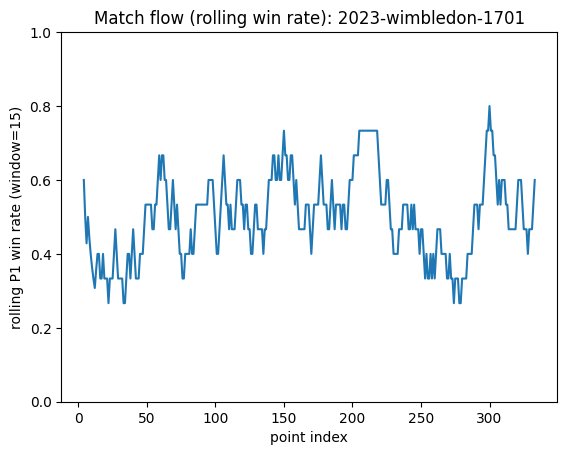

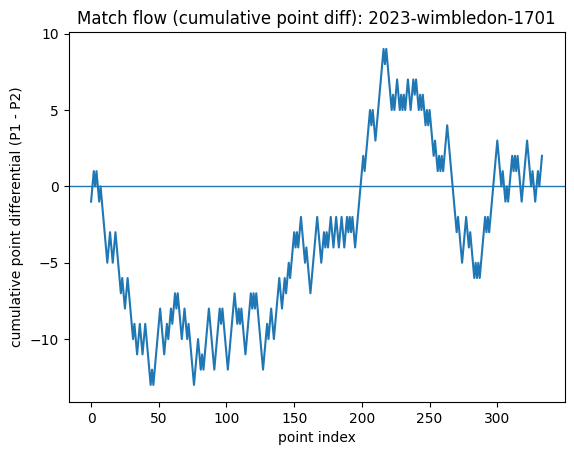

In [9]:
# 以某一场比赛为例：建议先拿题目点名那场 match_id = "2023-wimbledon-1701"
target_match = "2023-wimbledon-1701"
g = df[df["match_id"] == target_match].sort_values(["set_no","game_no","point_no"]).copy()
print("target match rows:", len(g))

# p1 是否赢 point：1/0
g["p1_win"] = np.where(g["point_victor"] == 1, 1,
                       np.where(g["point_victor"] == 2, 0, np.nan))

# rolling window
W = 15  # 你可调 10/15/20
g["roll_p1_winrate"] = g["p1_win"].rolling(W, min_periods=max(5, W//3)).mean()
g["cum_point_diff_p1"] = (g["p1_win"].fillna(0) - (1-g["p1_win"].fillna(0))).cumsum()

plt.figure()
plt.plot(g["roll_p1_winrate"].values)
plt.ylim(0,1)
plt.xlabel("point index")
plt.ylabel(f"rolling P1 win rate (window={W})")
plt.title(f"Match flow (rolling win rate): {target_match}")
plt.show()

plt.figure()
plt.plot(g["cum_point_diff_p1"].values)
plt.axhline(0, linewidth=1)
plt.xlabel("point index")
plt.ylabel("cumulative point differential (P1 - P2)")
plt.title(f"Match flow (cumulative point diff): {target_match}")
plt.show()


game ends: 46
Correlation of rolling state at game end vs next point: 0.9077601503981599


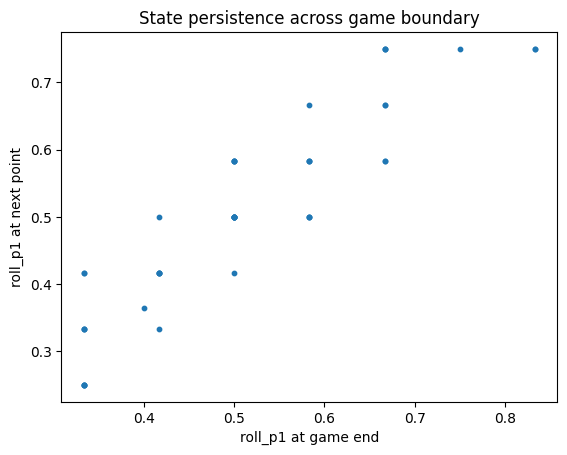

In [10]:
# 目标：看 game 结束时的“短期状态”是否会延续到下一 game
# 用 rolling win-rate 在 game 边界做对比

g = df[df["match_id"] == target_match].sort_values(["set_no","game_no","point_no"]).copy()
g["p1_win"] = np.where(g["point_victor"] == 1, 1,
                       np.where(g["point_victor"] == 2, 0, np.nan))
W = 12
g["roll_p1"] = g["p1_win"].rolling(W, min_periods=max(5, W//3)).mean()

# 标记 game 结束点：game_victor != 0 的行
if "game_victor" in g.columns:
    game_end = g[g["game_victor"].fillna(0) != 0].copy()
    print("game ends:", len(game_end))

    # 取 game 结束点的状态（roll_p1）与 下一点（下一game第一分）的状态
    idx = game_end.index.values
    next_idx = idx + 1
    next_idx = next_idx[next_idx < g.index.max()+1]
    pairs = []
    for i in idx:
        if i+1 in g.index:
            pairs.append((g.loc[i,"roll_p1"], g.loc[i+1,"roll_p1"]))
    pairs = np.array([p for p in pairs if pd.notna(p[0]) and pd.notna(p[1])])

    if len(pairs) > 0:
        corr = np.corrcoef(pairs[:,0], pairs[:,1])[0,1]
        print("Correlation of rolling state at game end vs next point:", corr)

        plt.figure()
        plt.scatter(pairs[:,0], pairs[:,1], s=10)
        plt.xlabel("roll_p1 at game end")
        plt.ylabel("roll_p1 at next point")
        plt.title("State persistence across game boundary")
        plt.show()


rally_count missing rate: 0.0
p1_distance_run missing rate: 0.0
p2_distance_run missing rate: 0.0
speed_mph missing rate: 0.029940119760479042


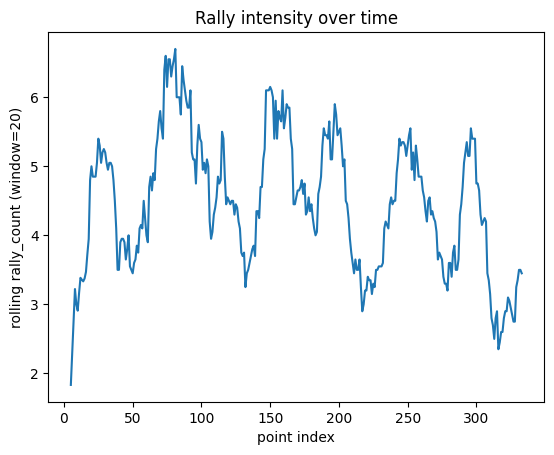

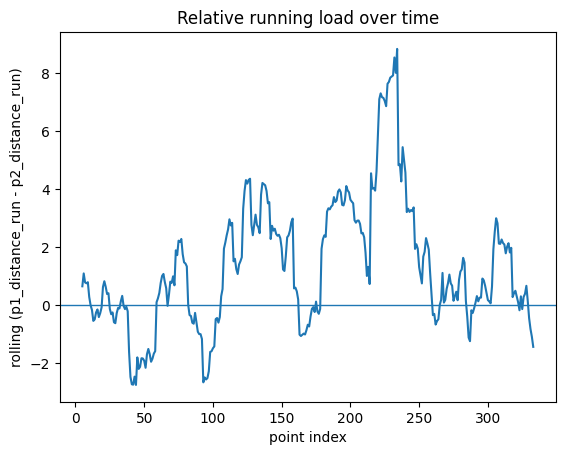

In [11]:
g = df[df["match_id"] == target_match].sort_values(["set_no","game_no","point_no"]).copy()

for col in ["rally_count","p1_distance_run","p2_distance_run","speed_mph"]:
    if col in g.columns:
        print(col, "missing rate:", g[col].isna().mean())

W = 20
if "rally_count" in g.columns:
    g["rally_roll"] = g["rally_count"].rolling(W, min_periods=max(5, W//3)).mean()
    plt.figure()
    plt.plot(g["rally_roll"].values)
    plt.xlabel("point index")
    plt.ylabel(f"rolling rally_count (window={W})")
    plt.title("Rally intensity over time")
    plt.show()

if "p1_distance_run" in g.columns and "p2_distance_run" in g.columns:
    g["dist_diff"] = g["p1_distance_run"] - g["p2_distance_run"]
    g["dist_diff_roll"] = g["dist_diff"].rolling(W, min_periods=max(5, W//3)).mean()
    plt.figure()
    plt.plot(g["dist_diff_roll"].values)
    plt.axhline(0, linewidth=1)
    plt.xlabel("point index")
    plt.ylabel(f"rolling (p1_distance_run - p2_distance_run)")
    plt.title("Relative running load over time")
    plt.show()


Detected swing points: 0
First few swing indices: []
Empty DataFrame
Columns: []
Index: []


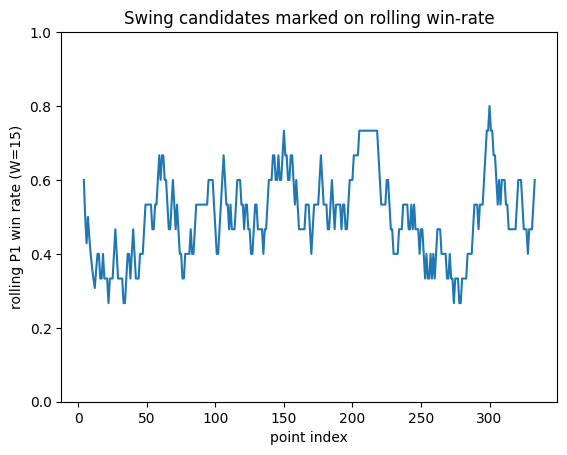

In [12]:
# 简单 swing 定义：rolling win-rate 从高位(>0.65)穿越到低位(<0.35) 或反向
# 这是“探索版”，后面你可改成更严谨的 change-point / HMM

g = df[df["match_id"] == target_match].sort_values(["set_no","game_no","point_no"]).copy()
g["p1_win"] = np.where(g["point_victor"] == 1, 1,
                       np.where(g["point_victor"] == 2, 0, np.nan))

W = 15
g["roll"] = g["p1_win"].rolling(W, min_periods=max(5, W//3)).mean()

hi, lo = 0.65, 0.35
g["state"] = np.where(g["roll"] >= hi, 1,
                      np.where(g["roll"] <= lo, -1, 0))  # 1: P1 dominance, -1: P2 dominance, 0: neutral

# swing：state 从 1 变 -1 或从 -1 变 1
g["state_shift"] = g["state"].diff()
swing_idx = g.index[(g["state"].shift(1) == 1) & (g["state"] == -1) |
                    (g["state"].shift(1) == -1) & (g["state"] == 1)].tolist()

print("Detected swing points:", len(swing_idx))
print("First few swing indices:", swing_idx[:10])

# 取 swing 前后窗口对比（比如前后 20 points）
K = 20
features = [c for c in ["rally_count","speed_mph","p1_distance_run","p2_distance_run","server_win","serve_no","is_break_pt"] if c in g.columns]

rows = []
for idx in swing_idx[:10]:  # 先看前10个，太多会乱
    center_pos = g.index.get_loc(idx)
    left = g.iloc[max(0, center_pos-K):center_pos]
    right = g.iloc[center_pos:min(len(g), center_pos+K)]

    row = {"swing_at_point_index": center_pos}
    for f in features:
        row[f+"_pre_mean"] = left[f].mean()
        row[f+"_post_mean"] = right[f].mean()
        row[f+"_delta"] = row[f+"_post_mean"] - row[f+"_pre_mean"]
    rows.append(row)

swing_feat = pd.DataFrame(rows)
print(swing_feat.head())

# 画一下 roll + swing 标记
plt.figure()
plt.plot(g["roll"].values)
for idx in swing_idx[:20]:
    plt.axvline(g.index.get_loc(idx), linewidth=1)
plt.ylim(0,1)
plt.xlabel("point index")
plt.ylabel(f"rolling P1 win rate (W={W})")
plt.title("Swing candidates marked on rolling win-rate")
plt.show()


count    32.000000
mean      1.937500
std       1.216486
min       1.000000
25%       1.000000
50%       1.500000
75%       2.250000
max       5.000000
Name: match_id, dtype: float64


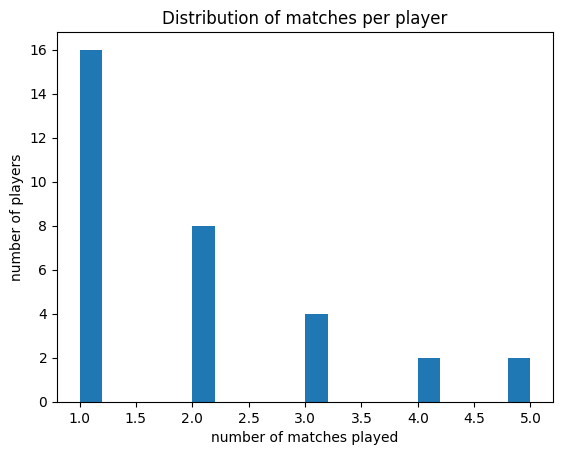

In [13]:
# 假设 player1 / player2 存在（若列名不同，替换即可）
players = pd.concat([
    df[["match_id","player1"]].rename(columns={"player1":"player"}),
    df[["match_id","player2"]].rename(columns={"player2":"player"})
]).drop_duplicates()

matches_per_player = players.groupby("player")["match_id"].nunique()
print(matches_per_player.describe())

plt.figure()
plt.hist(matches_per_player, bins=20)
plt.xlabel("number of matches played")
plt.ylabel("number of players")
plt.title("Distribution of matches per player")
plt.show()


count    32.000000
mean      0.483738
std       0.038504
min       0.380597
25%       0.468750
50%       0.489029
75%       0.507866
max       0.534050
Name: win, dtype: float64


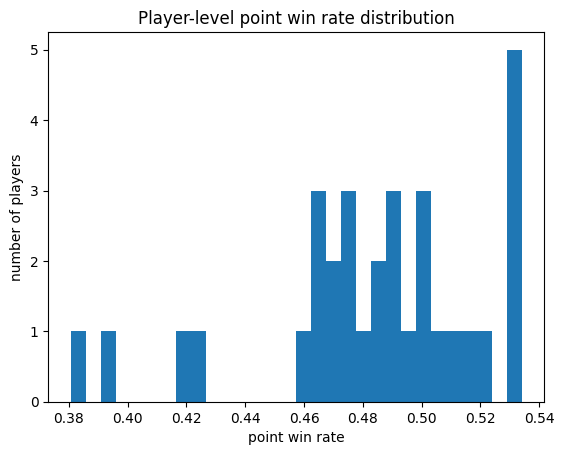

In [14]:
# 构造 player-level point outcome
df_long = pd.concat([
    df.assign(player=df["player1"], win=(df["point_victor"]==1).astype(int), is_server=(df["server"]==1).astype(int), is_break_pt=df["p1_break_pt"].fillna(0).astype(int)),
    df.assign(player=df["player2"], win=(df["point_victor"]==2).astype(int), is_server=(df["server"]==2).astype(int), is_break_pt=df["p2_break_pt"].fillna(0).astype(int))
]).reset_index(drop=True)

player_point_wr = df_long.groupby("player")["win"].mean()
print(player_point_wr.describe())

plt.figure()
plt.hist(player_point_wr, bins=30)
plt.xlabel("point win rate")
plt.ylabel("number of players")
plt.title("Player-level point win rate distribution")
plt.show()


count    32.000000
mean      0.353800
std       0.086409
min       0.149904
25%       0.312691
50%       0.366549
75%       0.411812
max       0.527588
Name: serve_advantage, dtype: float64


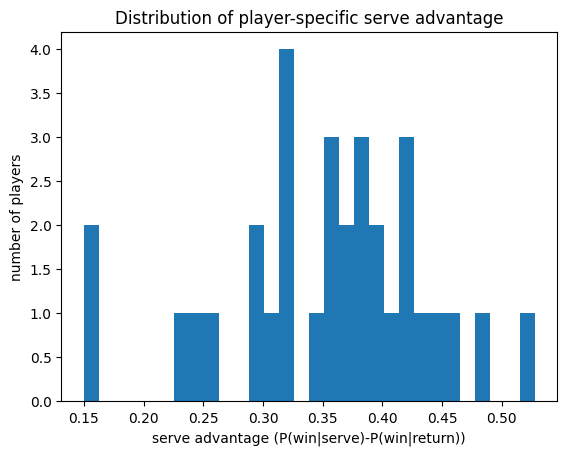

In [15]:
# 直接在 assign 时添加 is_server 标记
df_long = pd.concat([
    df.assign(player=df["player1"], win=(df["point_victor"]==1).astype(int), is_server=(df["server"]==1).astype(int)),
    df.assign(player=df["player2"], win=(df["point_victor"]==2).astype(int), is_server=(df["server"]==2).astype(int))
]).reset_index(drop=True)

serve_adv = df_long.groupby(["player","is_server"])["win"].mean().unstack()
serve_adv["serve_advantage"] = serve_adv[1] - serve_adv[0]
serve_adv = serve_adv.dropna()

print(serve_adv["serve_advantage"].describe())

plt.figure()
plt.hist(serve_adv["serve_advantage"], bins=30)
plt.xlabel("serve advantage (P(win|serve)-P(win|return))")
plt.ylabel("number of players")
plt.title("Distribution of player-specific serve advantage")
plt.show()


count    32.000000
mean      2.078156
std       0.198463
min       1.659574
25%       1.956038
50%       2.122024
75%       2.192915
max       2.547009
dtype: float64


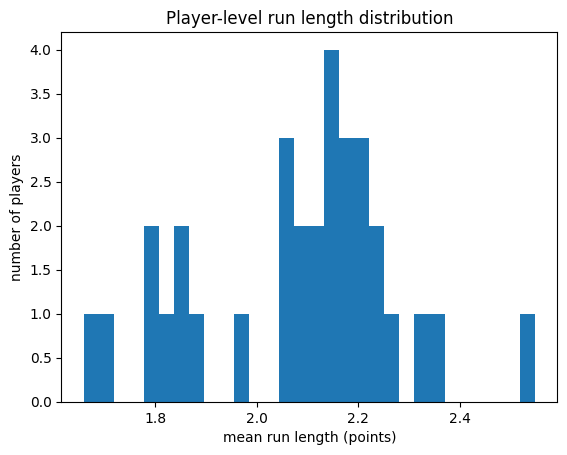

In [16]:
def player_run_lengths(match_df, player_name):
    g = match_df.sort_values(["set_no","game_no","point_no"])
    wins = np.where(
        ((g["player1"] == player_name) & (g["point_victor"] == 1)) |
        ((g["player2"] == player_name) & (g["point_victor"] == 2)),
        1, 0
    )
    runs, cur = [], 0
    for w in wins:
        if w == 1:
            cur += 1
        else:
            if cur > 0:
                runs.append(cur)
            cur = 0
    if cur > 0:
        runs.append(cur)
    return runs

player_run_mean = {}

for player in players["player"].unique():
    runs = []
    for mid, g in df.groupby("match_id"):
        if player in g[["player1","player2"]].values:
            runs.extend(player_run_lengths(g, player))
    if len(runs) >= 10:
        player_run_mean[player] = np.mean(runs)

run_df = pd.Series(player_run_mean)
print(run_df.describe())

plt.figure()
plt.hist(run_df, bins=30)
plt.xlabel("mean run length (points)")
plt.ylabel("number of players")
plt.title("Player-level run length distribution")
plt.show()


count    32.000000
mean      0.498615
std       0.127819
min       0.250000
25%       0.430254
50%       0.493777
75%       0.558712
max       0.777778
Name: win, dtype: float64


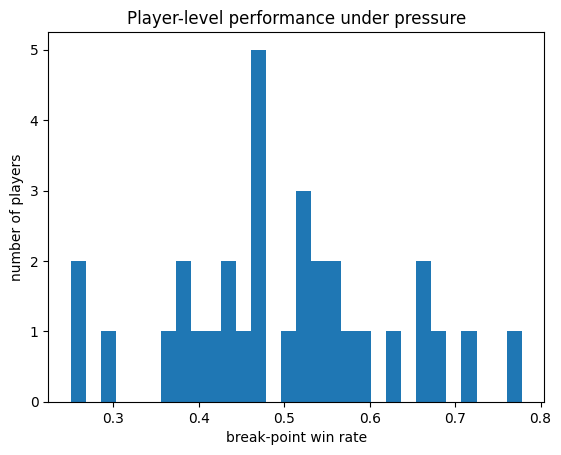

In [17]:
# is_break_pt 已在构造 df_long 时添加
bp_perf = df_long[df_long["is_break_pt"] == 1].groupby("player")["win"].mean()
bp_perf = bp_perf[bp_perf.notna()]

print(bp_perf.describe())

plt.figure()
plt.hist(bp_perf, bins=30)
plt.xlabel("break-point win rate")
plt.ylabel("number of players")
plt.title("Player-level performance under pressure")
plt.show()


In [18]:
# 计算每个 player 的 momentum volatility（rolling win rate 的波动性）
W = 10  # rolling window
vol_data = []
for player in df_long["player"].unique():
    player_df = df_long[df_long["player"] == player].sort_values(["match_id", "point_no"], ignore_index=True)
    player_df["rolling_wr"] = player_df["win"].rolling(W, min_periods=max(1, W//2)).mean()
    volatility = player_df["rolling_wr"].std()
    vol_data.append({"player": player, "volatility": volatility})

vol_df = pd.DataFrame(vol_data).set_index("player")["volatility"]
print("Momentum volatility (rolling WR std):")
print(vol_df.describe())


Momentum volatility (rolling WR std):
count    32.000000
mean      0.136726
std       0.013746
min       0.110697
25%       0.127653
50%       0.134506
75%       0.142012
max       0.175870
Name: volatility, dtype: float64


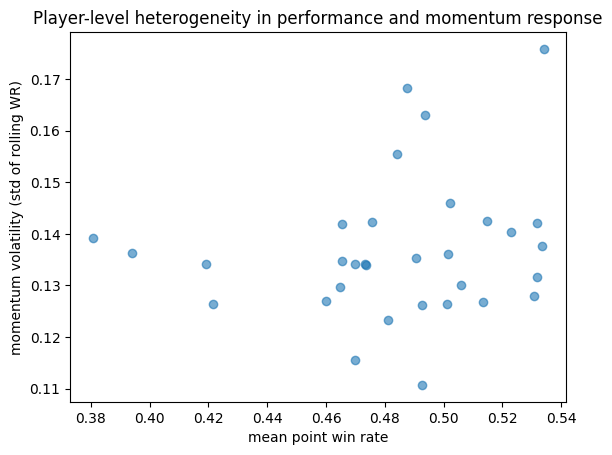

In [19]:
common = player_point_wr.to_frame("mean_wr") \
    .join(vol_df.to_frame("volatility"), how="inner")

plt.figure()
plt.scatter(common["mean_wr"], common["volatility"], alpha=0.6)
plt.xlabel("mean point win rate")
plt.ylabel("momentum volatility (std of rolling WR)")
plt.title("Player-level heterogeneity in performance and momentum response")
plt.show()
